In [70]:
# =========================================
# STEP 1: IMPORT LIBRARIES
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib

In [71]:
# =========================================
# STEP 2: RF SIGNAL GENERATION
# =========================================

fs = 1000
t = np.linspace(0, 1, fs)

# Clean signal
signal_clean = np.sin(2 * np.pi * 50 * t)

# Narrowband interference
narrowband = signal_clean + 0.5 * np.sin(2 * np.pi * 200 * t)

# Broadband interference
broadband = signal_clean + np.random.normal(0, 0.5, fs)

# Impulsive interference
impulsive = signal_clean.copy()
impulsive[np.random.randint(0, fs, 20)] += 2

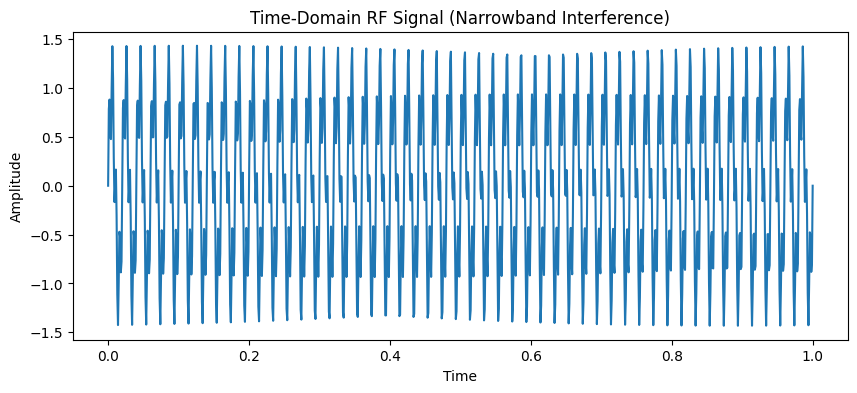

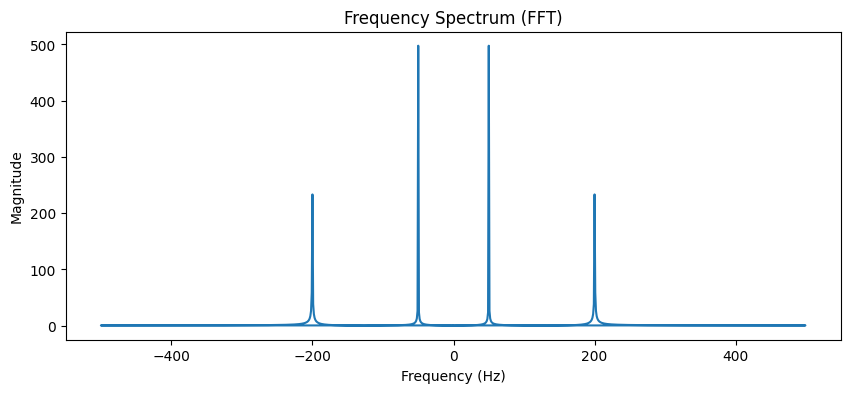

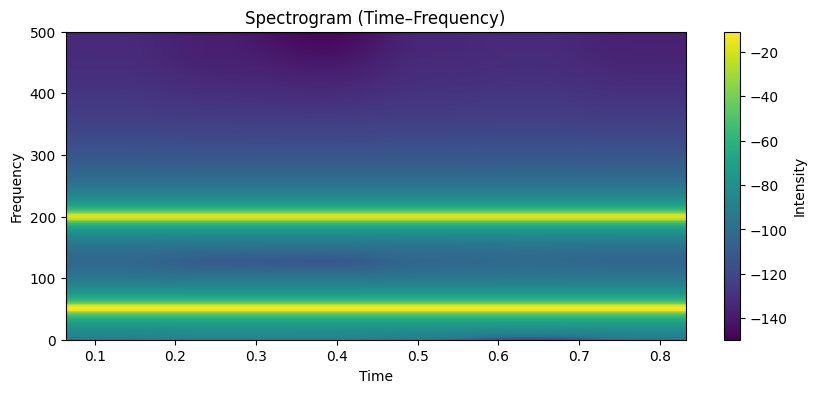

In [72]:
# =========================================
# STEP 3: SIGNAL VISUALIZATION
# =========================================

plt.figure(figsize=(10,4))
plt.plot(t, narrowband)
plt.title("Time-Domain RF Signal (Narrowband Interference)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

yf = fft(narrowband)
xf = fftfreq(len(narrowband), 1/fs)

plt.figure(figsize=(10,4))
plt.plot(xf, np.abs(yf))
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

plt.figure(figsize=(10,4))
plt.specgram(narrowband, Fs=fs)
plt.title("Spectrogram (Time–Frequency)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Intensity")
plt.show()

In [73]:
# =========================================
# STEP 4: FEATURE EXTRACTION FUNCTIONS
# =========================================

def extract_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.max(signal),
        np.min(signal),
        skew(signal),
        kurtosis(signal)
    ]

def segment_signal(signal, segment_length=100):
    segments = []
    for i in range(0, len(signal) - segment_length, segment_length):
        segments.append(signal[i:i + segment_length])
    return segments

In [76]:
# =========================================
# STEP 5: CREATE SCALED FEATURE DATASET
# =========================================

segments_clean = segment_signal(signal_clean)
segments_narrow = segment_signal(narrowband)
segments_broad = segment_signal(broadband)
segments_impulse = segment_signal(impulsive)

X = []
y = []

for seg in segments_clean:
    X.append(extract_features(seg))
    y.append(0)

for seg in segments_narrow:
    X.append(extract_features(seg))
    y.append(1)

for seg in segments_broad:
    X.append(extract_features(seg))
    y.append(2)

for seg in segments_impulse:
    X.append(extract_features(seg))
    y.append(3)

X = np.array(X)
y = np.array(y)

feature_df = pd.DataFrame(
    X,
    columns=["mean", "std", "max", "min", "skewness", "kurtosis"]
)
feature_df["label"] = y

feature_df.to_csv(r"D:\AI_RFI_Detection_Project\data\processed/rfi_features_scaled.csv", index=False)
feature_df.head()

,mean,std,max,min,skewness,kurtosis,label
0,-0.000142,0.706762,0.999999,-0.999989,0.000603,-1.498571,0
1,-0.000110,0.706756,0.999455,-0.999346,0.000472,-1.498523,0
2,-0.000079,0.706752,0.997923,-0.997715,0.000339,-1.498486,0
3,-0.000047,0.706749,0.995404,-0.995098,0.000204,-1.498462,0
4,-0.000016,0.706747,0.991900,-0.991496,0.000068,-1.498449,0


Detection Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.88      0.93         8

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11



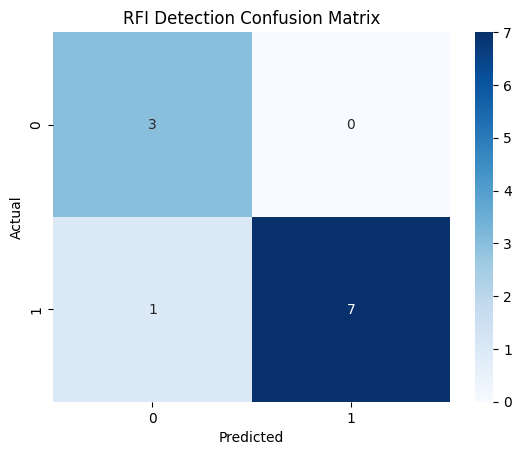

['D:\\AI_RFI_Detection_Project\\models/rfi_detector.pkl']

In [78]:
# =========================================
# STEP 6: RFI DETECTION (YES / NO)
# =========================================

df = feature_df.copy()
df["detection_label"] = df["label"].apply(lambda x: 0 if x == 0 else 1)

X_det = df[["mean","std","max","min","skewness","kurtosis"]]
y_det = df["detection_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X_det, y_det, test_size=0.3, random_state=42, stratify=y_det
)

rf_detector = RandomForestClassifier(n_estimators=200, random_state=42)
rf_detector.fit(X_train, y_train)

y_pred = rf_detector.predict(X_test)

print("Detection Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("RFI Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

joblib.dump(rf_detector, r"D:\AI_RFI_Detection_Project\models/rfi_detector.pkl")

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



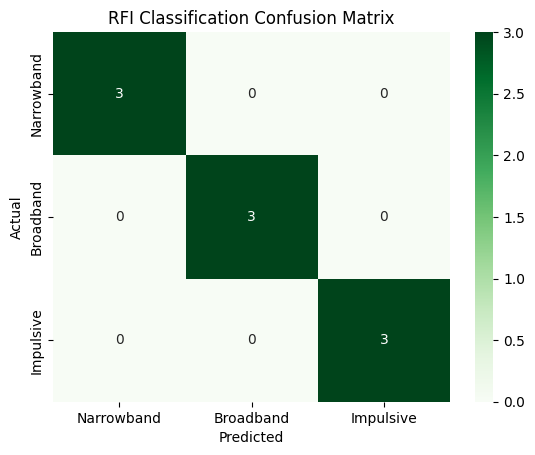

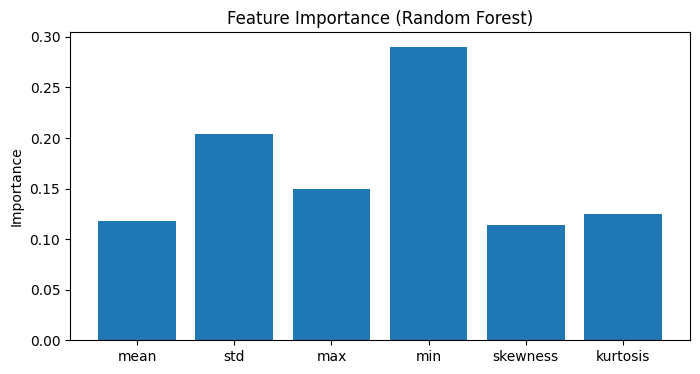

['D:\\AI_RFI_Detection_Project\\models/rfi_classifier.pkl']

In [80]:
# =========================================
# STEP 7: RFI CLASSIFICATION (TYPE)
# =========================================

cls_df = df[df["label"] != 0]

X_cls = cls_df[["mean","std","max","min","skewness","kurtosis"]]
y_cls = cls_df["label"]

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42)
rf_classifier.fit(Xc_tr, yc_tr)

yc_pred = rf_classifier.predict(Xc_te)

print(classification_report(yc_te, yc_pred))

cmc = confusion_matrix(yc_te, yc_pred)
sns.heatmap(
    cmc, annot=True, fmt="d", cmap="Greens",
    xticklabels=["Narrowband","Broadband","Impulsive"],
    yticklabels=["Narrowband","Broadband","Impulsive"]
)
plt.title("RFI Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

importances = rf_classifier.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(X_cls.columns, importances)
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.show()

joblib.dump(rf_classifier, r"D:\AI_RFI_Detection_Project\models/rfi_classifier.pkl")

In [81]:
# =========================================
# STEP 7B: MODEL COMPARISON
# =========================================

def evaluate_model(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    return {
        "Accuracy": accuracy_score(yte, yp),
        "Precision": precision_score(yte, yp, average="weighted"),
        "Recall": recall_score(yte, yp, average="weighted"),
        "F1-Score": f1_score(yte, yp, average="weighted")
    }

k_val = min(5, len(Xc_tr))

models = {
    "SVM": SVC(kernel="rbf"),
    "kNN": KNeighborsClassifier(n_neighbors=k_val),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, Xc_tr, Xc_te, yc_tr, yc_te)

comparison_df = pd.DataFrame(results).T
comparison_df

,Accuracy,Precision,Recall,F1-Score
SVM,0.888889,0.916667,0.888889,0.885714
kNN,0.777778,0.805556,0.777778,0.774603
Random Forest,1.000000,1.000000,1.000000,1.000000


In [82]:
# Save comparison results
comparison_df.to_csv(r"D:\AI_RFI_Detection_Project\results/model_comparison.csv")